In [1]:
import sys, numpy, math
import scipy.stats as scipystats
import matplotlib.pyplot as plt
import numpy as np
import re
from scipy.stats import beta

from mpl_toolkits.mplot3d import Axes3D

sys.path.append('/home/lethalfang/apps/seqc2/somaticseq/')
sys.path.append('/home/lethalfang/apps/seqc2/somaticseq/utilities')

import genomic_file_handlers as genome
from bedFileHandler import BedFile

%matplotlib inline

# Deemed colorblind safe: http://colorbrewer2.org/#type=diverging&scheme=PiYG&n=4
highConfColor     ='#1b9e77'
medConfColor      ='#7570b3'
lowConfColor      ='#d95f02'
unclassifiedColor ='black'

In [2]:
gfile  = '/home/lethalfang/Documents/Bina/SMWG/AmpliSeqValidation/gSnv.ValidationAnnotation.Inspected.csv'
gIndel = '/home/lethalfang/Documents/Bina/SMWG/AmpliSeqValidation/gIndel.ValidationAnnotation.Inspected.csv'

In [3]:
call_p_100 = []
call_p_90 = []
call_p_50to80 = []
call_p_00 = []

validated = []
invalidated = []
unknown = []
gGoldTVAF = []
gValidatedTVAF = []

call_p_in_id = r'called_prob=(1|0.[0-9]+|[1-9].[0-9]+e\-[0-9]+)\b'
medianvaf_in_id = r'Median_AF=(1|0\.[0-9]+)'

In [4]:
with open(gfile) as snv:
    
    line_i = snv.readline().rstrip()
    header = line_i.split('\t')
    
    i_ID        = header.index('ID')
    i_filter    = header.index('FILTER')
    i_validated = header.index('VALIDATED')
    i_vdp      = header.index('NormalVDP')
    i_dp       = header.index('NormalDP')
    
    line_i = snv.readline().rstrip()
    
    while line_i:
        
        item = line_i.split('\t')
        
        goldvaf = float( re.search(medianvaf_in_id, item[i_ID]).groups()[0] )
        gGoldTVAF.append( goldvaf )
        
        try:
            gValidatedTVAF.append( int(item[i_vdp]) / int(item[i_dp])  )
        except ZeroDivisionError:
            gValidatedTVAF.append( float('nan'))
        
        call_p = float( re.search(call_p_in_id, item[i_ID]).groups()[0] )

        if call_p == 1:
            call_p_100.append(True)
            call_p_90.append(False)
            call_p_50to80.append(False)
            call_p_00.append(False)
        elif call_p >= 0.9:
            call_p_100.append(False)
            call_p_90.append(True)
            call_p_50to80.append(False)
            call_p_00.append(False)
        elif call_p >= 0.5:
            call_p_100.append(False)
            call_p_90.append(False)
            call_p_50to80.append(True)
            call_p_00.append(False)
        elif call_p >= 0:
            call_p_100.append(False)
            call_p_90.append(False)
            call_p_50to80.append(False)
            call_p_00.append(True)
        
        
        if 'YES' in item[i_validated] or 'LIKELY' in item[i_validated]:
            validated.append(True)
            invalidated.append(False)
            unknown.append(False)
        elif item[i_validated] == 'INSPECTION,NO' or item[i_validated] == 'NO':
            validated.append(False)
            invalidated.append(True)
            unknown.append(False)
        else:
            validated.append(False)
            invalidated.append(False)
            unknown.append(True)
                
        line_i = snv.readline().rstrip()

In [5]:
call_p_100 = np.array(call_p_100, dtype=bool)
call_p_90 = np.array(call_p_90, dtype=bool)
call_p_50to80 = np.array(call_p_50to80, dtype=bool)
call_p_00 = np.array(call_p_00, dtype=bool)

validated = np.array(validated, dtype=bool)
invalidated = np.array(invalidated, dtype=bool)
unknown = np.array(unknown, dtype=bool)

gValidatedTVAF = np.array(gValidatedTVAF)
gGoldTVAF = np.array(gGoldTVAF)

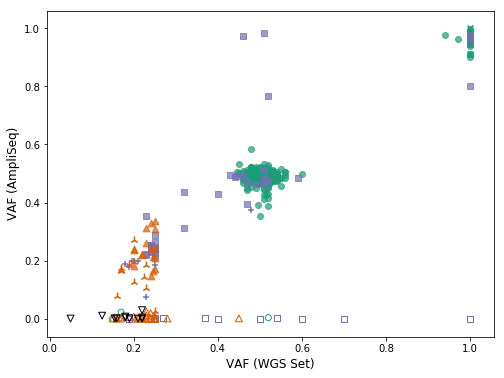

In [6]:
plt.figure(figsize=(8,6))

ms=36

plt.scatter(gGoldTVAF[ np.all( (call_p_100, validated), axis=0 ) ], \
            gValidatedTVAF[ np.all( (call_p_100, validated), axis=0 ) ] , s=ms, marker='o', color=highConfColor, alpha=0.7  )

plt.scatter(gGoldTVAF[ np.all( (call_p_90, validated), axis=0 ) ], \
            gValidatedTVAF[ np.all( (call_p_90, validated), axis=0 ) ] , s=ms, marker='s',  color=medConfColor, alpha=0.7  )

plt.scatter(gGoldTVAF[ np.all( (call_p_50to80, validated), axis=0 ) ], \
            gValidatedTVAF[ np.all( (call_p_50to80, validated), axis=0 ) ] , s=ms*1.3, marker='^', color=lowConfColor, alpha=0.7  )

plt.scatter(gGoldTVAF[ np.all( (call_p_00, validated), axis=0 ) ], \
            gValidatedTVAF[ np.all( (call_p_00, validated), axis=0 ) ] ,s=ms*1.3, marker='v',  color=unclassifiedColor, alpha=0.7  )

#plt.legend(('SCP=1', '1>SCP≥0.9', '0.9>SCP≥0.5', '0.5>SCP>0'), fontsize=12)

plt.scatter(gGoldTVAF[ np.all( (call_p_100, invalidated), axis=0 ) ], \
            gValidatedTVAF[ np.all( (call_p_100, invalidated), axis=0 ) ], s=ms, marker='o', color=highConfColor, facecolors='none')

plt.scatter(gGoldTVAF[ np.all( (call_p_90, invalidated), axis=0 ) ], \
            gValidatedTVAF[ np.all( (call_p_90, invalidated), axis=0 ) ], s=ms, marker='s', color=medConfColor, facecolors='none')

plt.scatter(gGoldTVAF[ np.all( (call_p_50to80, invalidated), axis=0 ) ], \
            gValidatedTVAF[ np.all( (call_p_50to80, invalidated), axis=0 ) ], s=ms*1.3, marker='^', color=lowConfColor, facecolors='none')

plt.scatter(gGoldTVAF[ np.all( (call_p_00, invalidated), axis=0 ) ], \
            gValidatedTVAF[ np.all( (call_p_00, invalidated), axis=0 ) ], s=ms*1.3, marker='v', color=unclassifiedColor, facecolors='none')


plt.scatter(gGoldTVAF[ np.all( (call_p_100, unknown), axis=0 ) ], \
            gValidatedTVAF[ np.all( (call_p_100, unknown), axis=0 ) ], s=ms, marker='x', color=highConfColor)

plt.scatter(gGoldTVAF[ np.all( (call_p_90, unknown), axis=0 ) ], \
            gValidatedTVAF[ np.all( (call_p_90, unknown), axis=0 ) ], s=ms, marker='+', color=medConfColor)

plt.scatter(gGoldTVAF[ np.all( (call_p_50to80, unknown), axis=0 ) ], \
            gValidatedTVAF[ np.all( (call_p_50to80, unknown), axis=0 ) ], s=ms*1.8, marker='2', color=lowConfColor)

plt.scatter(gGoldTVAF[ np.all( (call_p_00, unknown), axis=0 ) ], \
            gValidatedTVAF[ np.all( (call_p_00, unknown), axis=0 ) ], s=ms*1.8, marker='1', color=unclassifiedColor)


plt.xlabel('VAF (WGS Set)', size=12)
plt.ylabel('VAF (AmpliSeq)', size=12)


plt.savefig('../Main_Figures/Fig_3b_ampliseq_germline_snv.pdf', bbox_inches='tight')

In [7]:
for cate_i in call_p_100, call_p_90, call_p_50to80, call_p_00:
    
    total_i = sum(cate_i)
    total_validated = sum(np.all((cate_i, validated), axis=0))
    total_invalidated = sum(np.all((cate_i, invalidated), axis=0))
    validate_rate = total_validated / (total_validated + total_invalidated)
    interpretable_rate = (total_validated + total_invalidated)/total_i
    
    print('%g\t(%i/%i) %.1f%%\t(%i/%i) %.1f%%\t%.1f%%' % (total_i, total_validated+total_invalidated, total_i, 100*interpretable_rate, total_validated, total_validated + total_invalidated, 100*validate_rate, 100*interpretable_rate*validate_rate) )

422	(419/422) 99.3%	(416/419) 99.3%	98.6%
63	(54/63) 85.7%	(41/54) 75.9%	65.1%
68	(56/68) 82.4%	(17/56) 30.4%	25.0%
11	(11/11) 100.0%	(0/11) 0.0%	0.0%


In [8]:
x = []
y = []
for i,j in zip(gGoldTVAF[ call_p_100 ], gValidatedTVAF[ call_p_100]):
    if (not np.isnan(i)) and (not np.isnan(j)):
        x.append(i)
        y.append(j)

scipystats.pearsonr(x, y)

(0.9860781671935608, 0.0)

In [9]:
indel_call_p_100 = []
indel_call_p_90 = []

indel_validated = []
indel_invalidated = []
indel_unknown = []
indel_gGoldTVAF = []
indel_gValidatedTVAF = []


with open(gIndel) as indel:
    
    line_i = indel.readline().rstrip()
    header = line_i.split('\t')
    
    i_ID        = header.index('ID')
    i_filter    = header.index('FILTER')
    i_validated = header.index('VALIDATED')
    i_vdp       = header.index('NormalVDP')
    i_dp        = header.index('NormalDP')
    
    line_i = indel.readline().rstrip()
    
    while line_i:
        
        item = line_i.split('\t')
        
        indel_goldvaf = float( re.search(medianvaf_in_id, item[i_ID]).groups()[0] )
        indel_gGoldTVAF.append( indel_goldvaf )
        
        try:
            indel_gValidatedTVAF.append( int(item[i_vdp]) / int(item[i_dp])  )
        except ZeroDivisionError:
            indel_gValidatedTVAF.append( float('nan'))
        
        indel_call_p = float( re.search(call_p_in_id, item[i_ID]).groups()[0] )

        if indel_call_p == 1:
            indel_call_p_100.append(True)
            indel_call_p_90.append(False)
        elif indel_call_p >= 0.9:
            indel_call_p_100.append(False)
            indel_call_p_90.append(True)
        elif indel_call_p >= 0.5:
            indel_call_p_100.append(False)
            indel_call_p_90.append(False)
        elif indel_call_p >= 0:
            indel_call_p_100.append(False)
            indel_call_p_90.append(False)
        
        
        if 'YES' in item[i_validated] or 'LIKELY' in item[i_validated]:
            indel_validated.append(True)
            indel_invalidated.append(False)
            indel_unknown.append(False)
        elif item[i_validated] == 'INSPECTION,NO' or item[i_validated] == 'NO':
            indel_validated.append(False)
            indel_invalidated.append(True)
            indel_unknown.append(False)
        else:
            indel_validated.append(False)
            indel_invalidated.append(False)
            indel_unknown.append(True)
                
        line_i = indel.readline().rstrip()
        

indel_call_p_100    = np.array(indel_call_p_100,    dtype=bool)
indel_call_p_90     = np.array(indel_call_p_90,     dtype=bool)

indel_validated   = np.array(indel_validated,   dtype=bool)
indel_invalidated = np.array(indel_invalidated, dtype=bool)
indel_unknown     = np.array(indel_unknown,     dtype=bool)

indel_gValidatedTVAF = np.array(indel_gValidatedTVAF)
indel_gGoldTVAF      = np.array(indel_gGoldTVAF)

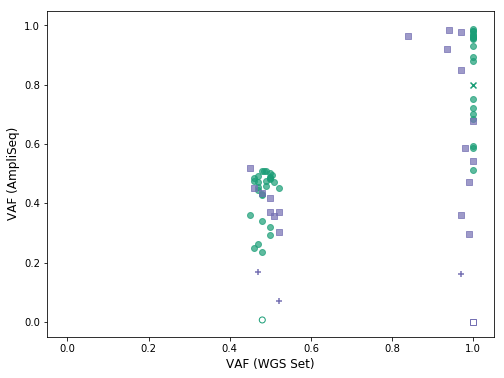

In [10]:
plt.figure(figsize=(8,6))

m=36

plt.scatter(indel_gGoldTVAF[ np.all( (indel_call_p_100, indel_validated), axis=0 ) ], \
            indel_gValidatedTVAF[ np.all( (indel_call_p_100, indel_validated), axis=0 ) ] , s=ms, marker='o', color=highConfColor, alpha=0.7  )

plt.scatter(indel_gGoldTVAF[ np.all( (indel_call_p_90, indel_validated), axis=0 ) ], \
            indel_gValidatedTVAF[ np.all( (indel_call_p_90, indel_validated), axis=0 ) ] , s=ms, marker='s', color=medConfColor, alpha=0.7  )

#plt.legend(('SCP=1', '1>SCP≥0.9', '0.9>SCP≥0.5', '0.5>SCP>0'), fontsize=12)

plt.scatter(indel_gGoldTVAF[ np.all( (indel_call_p_100, indel_invalidated), axis=0 ) ], \
            indel_gValidatedTVAF[ np.all( (indel_call_p_100, indel_invalidated), axis=0 ) ], s=ms, marker='o', color=highConfColor, facecolors='none')

plt.scatter(indel_gGoldTVAF[ np.all( (indel_call_p_90, indel_invalidated), axis=0 ) ], \
            indel_gValidatedTVAF[ np.all( (indel_call_p_90, indel_invalidated), axis=0 ) ], s=ms, marker='s', color=medConfColor, facecolors='none')



plt.scatter(indel_gGoldTVAF[ np.all( (indel_call_p_100, indel_unknown), axis=0 ) ], \
            indel_gValidatedTVAF[ np.all( (indel_call_p_100, indel_unknown), axis=0 ) ], s=ms, marker='x', color=highConfColor)

plt.scatter(indel_gGoldTVAF[ np.all( (indel_call_p_90, indel_unknown), axis=0 ) ], \
            indel_gValidatedTVAF[ np.all( (indel_call_p_90, indel_unknown), axis=0 ) ], s=ms, marker='+', color=medConfColor)


plt.xlim(( -0.05, 1.05 ))
plt.ylim(( -0.05, 1.05 ))

plt.xlabel('VAF (WGS Set)', size=12)
plt.ylabel('VAF (AmpliSeq)', size=12)

plt.savefig('../Extended_Data_Figures/Extended_Data_Fig_04a_ampliseq_germline_indel.pdf', bbox_inches='tight')

In [11]:
gSnv     = '/home/lethalfang/Documents/Bina/SMWG/IonTorrentValidation/germlineSNVs.vcf.gz'
ionSnv   = '/home/lethalfang/Documents/Bina/SMWG/IonTorrentValidation/IonTorrentInfoForGermlineSNV.tsv.gz'
gIndel   = '/home/lethalfang/Documents/Bina/SMWG/IonTorrentValidation/germlineINDELs.vcf.gz'
ionIndel = '/home/lethalfang/Documents/Bina/SMWG/IonTorrentValidation/IonTorrentInfoForGermlineINDEL.tsv.gz'

In [12]:
call_p_in_id = r'called_prob=(1|0.[0-9]+|[1-9].[0-9]+e\-[0-9]+)\b'
medianvaf_in_id = r'Median_AF=(1|0\.[0-9]+)'

In [13]:
call_p_100    = []
call_p_90     = []
call_p_50to80 = []
call_p_00     = []
medianVAF     = []
ionVAF        = []

Validated   = []
Invalidated = []
Unknown     = []

with genome.open_textfile(gSnv) as vcfFile, genome.open_textfile(ionSnv) as tsvFile:

    vcfLine = vcfFile.readline().rstrip()
    while vcfLine.startswith('#'):
        vcfLine = vcfFile.readline().rstrip()
        
    tsvLine   = tsvFile.readline().rstrip()
    tsvHeader = tsvLine.split('\t')
    iDP       = tsvHeader.index('NORMAL_bam_DP')
    iAltFor   = tsvHeader.index('NORMAL_bam_ALT_FOR')
    iAltRev   = tsvHeader.index('NORMAL_bam_ALT_REV')
    
    tsvLine = tsvFile.readline().rstrip()
    
    while vcfLine:
        
        vcf_i = genome.Vcf_line(vcfLine)
        
        vaf_i = float(vcf_i.get_info_value('Median_AF'))
        medianVAF.append( vaf_i )
        
        prob_i = float(vcf_i.get_info_value('called_prob'))
        
        if prob_i == 1:
            call_p_100.append(True)
            call_p_90.append(False)
            call_p_50to80.append(False)
            call_p_00.append(False)
        elif prob_i >= 0.9:
            call_p_100.append(False)
            call_p_90.append(True)
            call_p_50to80.append(False)
            call_p_00.append(False)
        elif prob_i >= 0.5:
            call_p_100.append(False)
            call_p_90.append(False)
            call_p_50to80.append(True)
            call_p_00.append(False)
        else:
            call_p_100.append(False)
            call_p_90.append(False)
            call_p_50to80.append(False)
            call_p_00.append(True)

            
        tsvItem = tsvLine.split('\t')
        DP      = int(tsvItem[iDP])
        AltDP   = int(tsvItem[iAltFor]) + int(tsvItem[iAltRev])
        
        try:
            ionVAF.append( AltDP/DP )
        except ZeroDivisionError:
            ionVAF.append( 0 )
        
        assert vcf_i.position == int(tsvItem[1])

        
        # Simple rule to decide if validated or not:
        if DP >= 8:
            
            # VALIDATED
            if (AltDP >=2) and (AltDP/DP > 0.1):
                Validated.append(True)
                Invalidated.append(False)
                Unknown.append(False)
                        
            # INVALIDATED (NO variant signal)
            # Expect variant DP >= 5, but gets zero.
            elif AltDP == 0 and DP*vaf_i >= 5:
                Validated.append(False)
                Invalidated.append(True)
                Unknown.append(False)
            
            # UNKNOWN
            else:
                Validated.append(False)
                Invalidated.append(False)
                Unknown.append(True)

        # UNKNOWN  
        else:
            Validated.append(False)
            Invalidated.append(False)
            Unknown.append(True)
        
        vcfLine = vcfFile.readline().rstrip()
        tsvLine = tsvFile.readline().rstrip()

In [14]:
validated = np.array(Validated, dtype=bool)
invalidated = np.array(Invalidated, dtype=bool)
unknown = np.array(Unknown, dtype=bool)

call_p_100    = np.array(call_p_100, dtype=bool)
call_p_90     = np.array(call_p_90, dtype=bool)
call_p_50to80 = np.array(call_p_50to80, dtype=bool)
call_p_00     = np.array(call_p_00, dtype=bool)

medianVAF     = np.array(medianVAF)
ionVAF        = np.array(ionVAF)

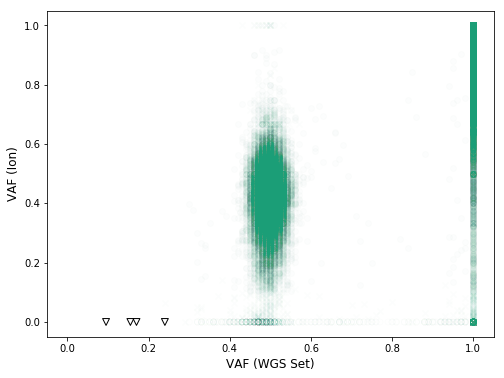

In [15]:
plt.figure(figsize=(8,6))

m=36

plt.scatter(-5, -5, marker='o', color=highConfColor)
plt.scatter(-5, -5, marker='s', color=medConfColor)
plt.scatter(-5, -5, marker='^', color=lowConfColor)
plt.scatter(-5, -5, marker='v', color=unclassifiedColor)

#plt.legend(('SCP=1', '1>SCP≥0.9', '0.9>SCP≥0.5', '0.5>SCP>0'), fontsize=12)

plt.scatter(medianVAF[ np.all( (call_p_100, validated), axis=0 ) ], \
            ionVAF[ np.all( (call_p_100, validated), axis=0 ) ] , s=ms, marker='o', color=highConfColor,alpha=0.01  )

plt.scatter(medianVAF[ np.all( (call_p_90, validated), axis=0 ) ], \
            ionVAF[ np.all( (call_p_90, validated), axis=0 ) ] , s=ms, marker='s', color=medConfColor,  )

plt.scatter(medianVAF[ np.all( (call_p_50to80, validated), axis=0 ) ], \
            ionVAF[ np.all( (call_p_50to80, validated), axis=0 ) ] , s=ms*1.3, marker='^', color=lowConfColor,  )

plt.scatter(medianVAF[ np.all( (call_p_00, validated), axis=0 ) ], \
            ionVAF[ np.all( (call_p_00, validated), axis=0 ) ] , s=ms*1.3, marker='v',  color=unclassifiedColor,   )


plt.scatter(medianVAF[ np.all( (call_p_100, invalidated), axis=0 ) ], \
            ionVAF[ np.all( (call_p_100, invalidated), axis=0 ) ], s=ms, marker='o', color=highConfColor, facecolors='none', alpha=0.01)

plt.scatter(medianVAF[ np.all( (call_p_90, invalidated), axis=0 ) ], \
            ionVAF[ np.all( (call_p_90, invalidated), axis=0 ) ], s=ms, marker='s', color=medConfColor, facecolors='none')

plt.scatter(medianVAF[ np.all( (call_p_50to80, invalidated), axis=0 ) ], \
            ionVAF[ np.all( (call_p_50to80, invalidated), axis=0 ) ], s=ms*1.3, marker='^', color=lowConfColor, facecolors='none')

plt.scatter(medianVAF[ np.all( (call_p_00, invalidated), axis=0 ) ], \
            ionVAF[ np.all( (call_p_00, invalidated), axis=0 ) ], s=ms*1.3, marker='v', color=unclassifiedColor, facecolors='none')


plt.scatter(medianVAF[ np.all( (call_p_100, unknown), axis=0 ) ], \
            ionVAF[ np.all( (call_p_100, unknown), axis=0 ) ], s=ms, marker='x', color=highConfColor, alpha=0.01)

plt.scatter(medianVAF[ np.all( (call_p_90, unknown), axis=0 ) ], \
            ionVAF[ np.all( (call_p_90, unknown), axis=0 ) ], s=ms, marker='+', color=medConfColor)

plt.scatter(medianVAF[ np.all( (call_p_50to80, unknown), axis=0 ) ], \
            ionVAF[ np.all( (call_p_50to80, unknown), axis=0 ) ], s=ms*1.8, marker='2', color=lowConfColor)

plt.scatter(medianVAF[ np.all( (call_p_00, unknown), axis=0 ) ], \
            ionVAF[ np.all( (call_p_00, unknown), axis=0 ) ], s=ms*1.8, marker='1', color=unclassifiedColor)

plt.xlim((-0.05, 1.05))
plt.ylim((-0.05, 1.05))

plt.xlabel('VAF (WGS Set)', size=12)
plt.ylabel('VAF (Ion)', size=12)

plt.savefig('../Main_Figures/Fig_3c_ion_germline_snv.pdf', bbox_inches='tight')

In [16]:
x = []
y = []
for i,j in zip(medianVAF[ call_p_100 ], ionVAF[ call_p_100 ]):
    if (not np.isnan(i)) and (not np.isnan(j)):
        x.append(i)
        y.append(j)

scipystats.pearsonr(x, y)

(0.7575391202939921, 0.0)

In [17]:
call_p_100    = []
call_p_90     = []
call_p_50to80 = []
call_p_00     = []
medianVAF     = []
ionVAF        = []

Validated   = []
Invalidated = []
Unknown     = []

with genome.open_textfile(gIndel) as vcfFile, genome.open_textfile(ionIndel) as tsvFile:

    vcfLine = vcfFile.readline().rstrip()
    while vcfLine.startswith('#'):
        vcfLine = vcfFile.readline().rstrip()
        
    tsvLine   = tsvFile.readline().rstrip()
    tsvHeader = tsvLine.split('\t')
    iDP       = tsvHeader.index('NORMAL_bam_DP')
    iAltFor   = tsvHeader.index('NORMAL_bam_ALT_FOR')
    iAltRev   = tsvHeader.index('NORMAL_bam_ALT_REV')
    
    tsvLine = tsvFile.readline().rstrip()
    
    while vcfLine:
        
        vcf_i = genome.Vcf_line(vcfLine)
        
        vaf_i = float(vcf_i.get_info_value('Median_AF'))
        medianVAF.append( vaf_i )
        
        prob_i = float(vcf_i.get_info_value('called_prob'))
        
        if prob_i == 1:
            call_p_100.append(True)
            call_p_90.append(False)
            call_p_50to80.append(False)
            call_p_00.append(False)
        elif prob_i >= 0.9:
            call_p_100.append(False)
            call_p_90.append(True)
            call_p_50to80.append(False)
            call_p_00.append(False)
        elif prob_i >= 0.5:
            call_p_100.append(False)
            call_p_90.append(False)
            call_p_50to80.append(True)
            call_p_00.append(False)
        else:
            call_p_100.append(False)
            call_p_90.append(False)
            call_p_50to80.append(False)
            call_p_00.append(True)

            
        tsvItem = tsvLine.split('\t')
        DP      = int(tsvItem[iDP])
        AltDP   = int(tsvItem[iAltFor]) + int(tsvItem[iAltRev])
        
        try:
            ionVAF.append( AltDP/DP )
        except ZeroDivisionError:
            ionVAF.append( 0 )
        
        assert vcf_i.position == int(tsvItem[1])

        
        # Simple rule to decide if validated or not:
        if DP >= 8:
            
            # VALIDATED
            if (AltDP >=2) and (AltDP/DP > 0.1):
                Validated.append(True)
                Invalidated.append(False)
                Unknown.append(False)
                        
            # INVALIDATED (NO variant signal)
            # Expect variant DP >= 5, but gets zero.
            elif AltDP == 0 and DP*vaf_i >= 5:
                Validated.append(False)
                Invalidated.append(True)
                Unknown.append(False)
            
            # UNKNOWN
            else:
                Validated.append(False)
                Invalidated.append(False)
                Unknown.append(True)

        # UNKNOWN  
        else:
            Validated.append(False)
            Invalidated.append(False)
            Unknown.append(True)
        
        vcfLine = vcfFile.readline().rstrip()
        tsvLine = tsvFile.readline().rstrip()

In [18]:
validated = np.array(Validated, dtype=bool)
invalidated = np.array(Invalidated, dtype=bool)
unknown = np.array(Unknown, dtype=bool)

call_p_100    = np.array(call_p_100, dtype=bool)
call_p_90     = np.array(call_p_90, dtype=bool)
call_p_50to80 = np.array(call_p_50to80, dtype=bool)
call_p_00     = np.array(call_p_00, dtype=bool)

medianVAF     = np.array(medianVAF)
ionVAF        = np.array(ionVAF)

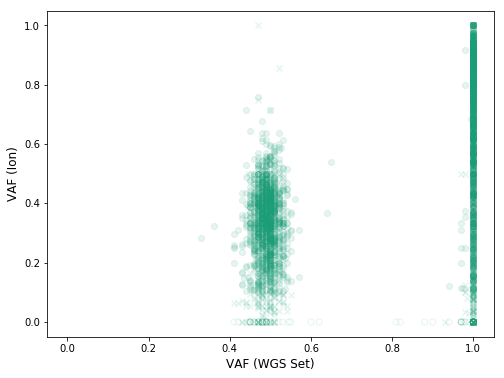

In [19]:
plt.figure(figsize=(8,6))

ms=36

plt.scatter(-5, -5, marker='o', color=highConfColor)
plt.scatter(-5, -5, marker='s', color=medConfColor)
plt.scatter(-5, -5, marker='^', color=lowConfColor)
plt.scatter(-5, -5, marker='v', color=unclassifiedColor)

#plt.legend(('SCP=1', '1>SCP≥0.9', '0.9>SCP≥0.5', '0.5>SCP>0'), fontsize=12)

plt.scatter(medianVAF[ np.all( (call_p_100, validated), axis=0 ) ], \
            ionVAF[ np.all( (call_p_100, validated), axis=0 ) ] , s=ms, marker='o', color=highConfColor, alpha=0.1  )

plt.scatter(medianVAF[ np.all( (call_p_90, validated), axis=0 ) ], \
            ionVAF[ np.all( (call_p_90, validated), axis=0 ) ] , s=ms, marker='s', color=medConfColor,  )

plt.scatter(medianVAF[ np.all( (call_p_50to80, validated), axis=0 ) ], \
            ionVAF[ np.all( (call_p_50to80, validated), axis=0 ) ] ,s=ms*1.3, marker='^',  color=lowConfColor,  )

plt.scatter(medianVAF[ np.all( (call_p_00, validated), axis=0 ) ], \
            ionVAF[ np.all( (call_p_00, validated), axis=0 ) ] , s=ms*1.3, marker='v', color=unclassifiedColor,   )


plt.scatter(medianVAF[ np.all( (call_p_100, invalidated), axis=0 ) ], \
            ionVAF[ np.all( (call_p_100, invalidated), axis=0 ) ], s=ms, marker='o', color=highConfColor, facecolors='none', alpha=0.1)

plt.scatter(medianVAF[ np.all( (call_p_90, invalidated), axis=0 ) ], \
            ionVAF[ np.all( (call_p_90, invalidated), axis=0 ) ], s=ms, marker='s', color=medConfColor, facecolors='none')

plt.scatter(medianVAF[ np.all( (call_p_50to80, invalidated), axis=0 ) ], \
            ionVAF[ np.all( (call_p_50to80, invalidated), axis=0 ) ], s=ms*1.3, marker='^', color=lowConfColor, facecolors='none')

plt.scatter(medianVAF[ np.all( (call_p_00, invalidated), axis=0 ) ], \
            ionVAF[ np.all( (call_p_00, invalidated), axis=0 ) ], s=ms*1.3, marker='v', color=unclassifiedColor, facecolors='none')


plt.scatter(medianVAF[ np.all( (call_p_100, unknown), axis=0 ) ], \
            ionVAF[ np.all( (call_p_100, unknown), axis=0 ) ], s=ms, marker='x', color=highConfColor, alpha=0.1)

plt.scatter(medianVAF[ np.all( (call_p_90, unknown), axis=0 ) ], \
            ionVAF[ np.all( (call_p_90, unknown), axis=0 ) ], s=ms, marker='+', color=medConfColor)

plt.scatter(medianVAF[ np.all( (call_p_50to80, unknown), axis=0 ) ], \
            ionVAF[ np.all( (call_p_50to80, unknown), axis=0 ) ], s=ms*1.8, marker='^', color=lowConfColor)

plt.scatter(medianVAF[ np.all( (call_p_00, unknown), axis=0 ) ], \
            ionVAF[ np.all( (call_p_00, unknown), axis=0 ) ], s=ms*1.8, marker='v',  color=unclassifiedColor)

plt.xlim((-0.05, 1.05))
plt.ylim((-0.05, 1.05))


plt.xlabel('VAF (WGS Set)', size=12)
plt.ylabel('VAF (Ion)', size=12)

plt.savefig('../Extended_Data_Figures/Extended_Data_Fig_04b_ion_germline_indel.pdf', bbox_inches='tight')

In [20]:
x = []
y = []
for i,j in zip(medianVAF[ call_p_100 ], ionVAF[ call_p_100 ]):
    if (not np.isnan(i)) and (not np.isnan(j)):
        x.append(i)
        y.append(j)

scipystats.pearsonr(x, y)

(0.5185030372766085, 2.9724954098235114e-199)